In [ ]:
!pip install qiskit --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector, entropy, Kraus, DensityMatrix


BLACK HOLE EVAPORATION: MARKOVIAN VS NON-MARKOVIAN

Starting Markovian simulation...

MARKOVIAN EVAPORATION SIMULATION
System: 10 qubits (Black Hole only)
No environment, no recovery mechanism

Step 1: R=1, B=9, S(R)=0.9977, S(B)=0.9977
Step 2: R=2, B=8, S(R)=1.9874, S(B)=1.9874
Step 3: R=3, B=7, S(R)=2.9574, S(B)=2.9574
Step 4: R=4, B=6, S(R)=3.8299, S(B)=3.8299
Step 5: R=5, B=5, S(R)=4.2347, S(B)=4.2347
Step 6: R=6, B=4, S(R)=3.7706, S(B)=3.7706
Step 7: R=7, B=3, S(R)=2.9443, S(B)=2.9443
Step 8: R=8, B=2, S(R)=1.9890, S(B)=1.9890
Step 9: R=9, B=1, S(R)=0.9995, S(B)=0.9995

✓ Markovian simulation complete

Starting Non-Markovian simulation...

NON-MARKOVIAN EVAPORATION SIMULATION
Black hole qubits: 8
Environment qubits: 3
Coupling strength: 0.3
Environment evolution strength: 1.0

Step 1: R=1, B=7, S(R)=0.9977, S(B)=2.0967, dS/dt=+0.0000
Step 2: R=2, B=6, S(R)=1.9764, S(B)=4.0459, dS/dt=+0.9787
Step 3: R=3, B=5, S(R)=2.9461, S(B)=4.5306, dS/dt=+0.9696
Step 4: R=4, B=4, S(R)=3.8595, S

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/markovian_vs_nonmarkovian.png'

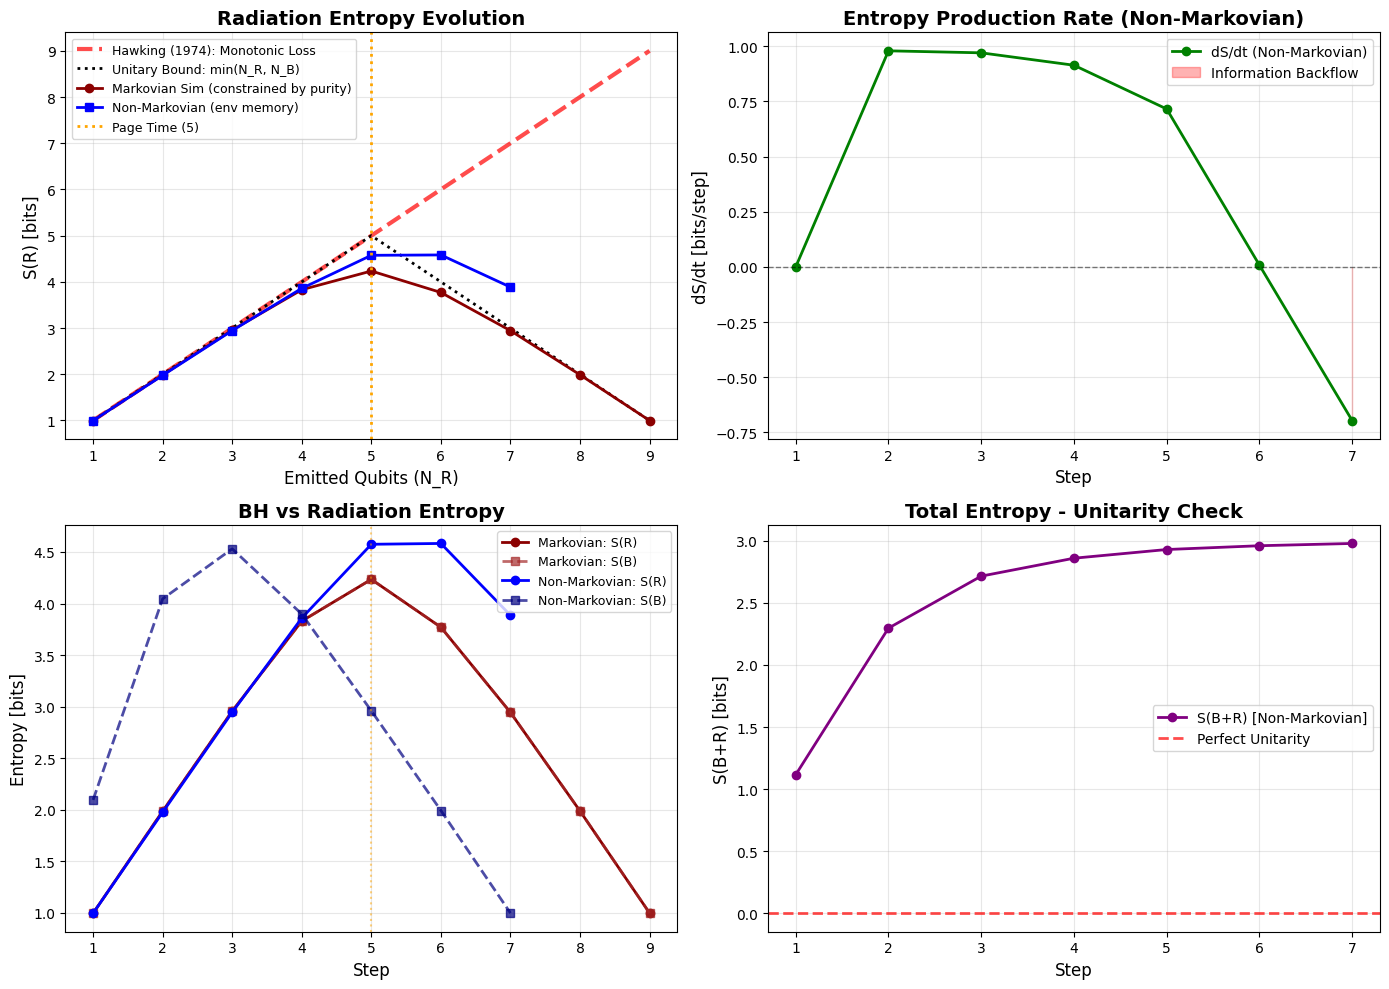

In [ ]:
# --- 1. System Definition Parameters ---

N_QUBITS = 8  # Total number of degrees of freedom (qubits)

B_INITIAL_SIZE = N_QUBITS # Initial size of the Black Hole (B) subsystem

R_INITIAL_SIZE = 0        # Initial size of the Radiation (R) subsystem



# --- 2. Evaporation Operation (Unitary) ---

def get_scrambling_unitary(qubit1_index, qubit2_index, num_qubits):

    """

    Creates a simple, generic two-qubit unitary gate to model entanglement and

    scrambling between two adjacent qubits.

    """

    qc = QuantumCircuit(num_qubits)

    # Apply a CNOT gate to entangle the two qubits

    qc.cx(qubit1_index, qubit2_index)

    # Apply local rotations to scramble the state

    qc.rz(np.pi / 4, qubit1_index)

    qc.ry(np.pi / 2, qubit2_index)



    # We return the whole circuit compositionally for simplicity in Colab

    return qc



def initialize_system(n_qubits):

    """Initializes the total system in a pure state (|00...0>)."""

    qc = QuantumCircuit(n_qubits)

    # All qubits start in the pure state |0>

    return qc



def simulate_evaporation(initial_qc, n_total):

    """

    Simulates the black hole evaporation process step-by-step and calculates

    the entanglement entropy of the radiation (R) subsystem.

    """

    current_circuit = initial_qc.copy()



    # Track results

    entanglement_entropies = []



    # Start with all qubits in B (Black Hole), R is empty

    b_qubits = list(range(n_total)) # Qubit indices currently in B

    r_qubits = []                    # Qubit indices currently in R



    print(f"--- Simulating {n_total}-Qubit Evaporation ---")



    # Loop through the evaporation process (emitting one qubit at a time)

    # Stop when the black hole has only one qubit left (or zero if n_total is odd).

    while len(b_qubits) > 1:



        # --- Evaporation Step ---



        # 1. Qubit to be emitted (the "edge" of B)

        qubit_to_emit = b_qubits.pop(0)



        # 2. Neighbor qubit in B for interaction (to ensure new entanglement)

        neighbor_qubit = b_qubits[0]



        # 3. Apply a unitary operation to model entanglement/scrambling

        scrambler_qc = get_scrambling_unitary(qubit_to_emit, neighbor_qubit, n_total)

        current_circuit.compose(scrambler_qc, inplace=True)



        # 4. Move the emitted qubit from B to R

        r_qubits.append(qubit_to_emit)



        # --- Entanglement Calculation ---



        # 5. Compute the current quantum state vector

        # This simulates the evolution of the total pure state (B+R)

        state_vector = Statevector.from_instruction(current_circuit)



        # 6. Calculate the reduced density matrix (rho_R) for the radiation (R)

        # We trace out the B qubits (the remaining b_qubits indices)

        b_indices = b_qubits

        rho_R = partial_trace(state_vector, b_indices)



        # 7. Compute the von Neumann entropy (S_vN) of the radiation (base=2 for bits)

        s_vn = entropy(rho_R, base=2)

        entanglement_entropies.append(s_vn)



        print(f"Step {len(r_qubits)}: B size = {len(b_qubits)}, R size = {len(r_qubits)}, S_vN = {s_vn:.4f}")



    return entanglement_entropies



def plot_page_curve(data, n_total):

    """

    Plots the simulated Page Curve and the theoretical S_min bound.

    """



    num_steps = len(data)



    # 1. X-Axis: Number of qubits in the radiation (N_R)

    r_qubit_count = list(range(1, num_steps + 1))



    # 2. Theoretical Page Curve Limit (S_min)

    # The maximum entanglement for a pure state is bounded by the entropy

    # of the smaller subsystem, which is approximated by the qubit count: min(N_R, N_B)

    theoretical_limit = []

    for n_r in r_qubit_count:

        n_b = n_total - n_r

        # The ideal Page Curve is approximated by min(N_R, N_B)

        # for a maximally chaotic (scrambled) process.

        S_min = min(n_r, n_b)

        theoretical_limit.append(S_min)



    # 3. Plotting

    plt.figure(figsize=(10, 6))



    # Simulated Entanglement Entropy (S_vN)

    plt.plot(r_qubit_count, data, label='Simulated Entanglement Entropy $S_{\\text{vN}}(R)$',

             marker='o', linestyle='-', color='blue')



    # Theoretical Bound

    plt.plot(r_qubit_count, theoretical_limit, label='Theoretical Max Entanglement $\\min(N_R, N_B)$',

             linestyle='--', color='red')



    # Page Time Marker

    page_time = n_total / 2

    plt.axvline(x=page_time, color='green', linestyle=':',

                label=f'Page Time ({page_time} qubits)')



    # Aesthetics

    plt.title(f'Simulated Page Curve for a {n_total}-Qubit Black Hole')

    plt.xlabel('Number of Qubits in Radiation Subsystem ($N_R$)')

    plt.ylabel('Entanglement Entropy ($S_{\\text{vN}}$ in bits)')

    plt.xticks(r_qubit_count + [page_time])

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.legend()

    plt.show()

    #



# --- Execution ---

initial_circuit = initialize_system(N_QUBITS)

page_curve_data = simulate_evaporation(initial_circuit, N_QUBITS)

plot_page_curve(page_curve_data, N_QUBITS)
